In [66]:
import math
# import random

import gym
import numpy

import jax
# import time
# from numpy import random

from jax import grad
import jax.numpy as np
from jax import random
from jax.ops import index, index_add, index_update


In [96]:
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib inline

In [35]:
def plotHeadingSteps(pos, target, ax = None, radius = None):
    if ax is None:
        f, ax = plt.subplots(figsize=(8, 8))
    R = radius if radius is not None else np.linalg.norm(target)+1

    ax.set_aspect("equal", "box")
    ax.set_xlim([-R, R])
    ax.set_ylim([-R, R])

    ax.plot(pos[0,:],pos[1,:])
    ax.scatter([0,target[0]], [0,target[1]], c="black")

In [37]:
np.hstack([0,np.cos(np.array([1,2,3,4]))])
np.hstack([np.zeros((2,1)),random.random_sample(2,2)])
# np.zeros((2,1))

AttributeError: module 'jax.random' has no attribute 'random_sample'

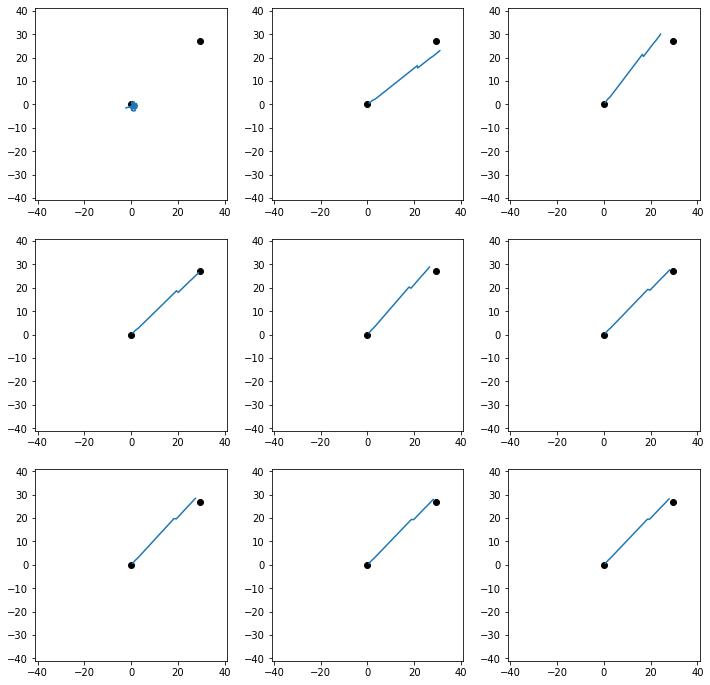

In [61]:
# trying to get to a target, taking steps of length 1 and choosing direction
key = jax.random.PRNGKey(1)

T=40
heading_inputs = random.uniform(key,(1,T))
targetDirection = random.uniform(key,(1,1))*2*np.pi
target = np.array([np.cos(targetDirection),np.sin(targetDirection)])*T

r,c = 3,3
f, axs = plt.subplots(r,c,figsize=(4*c,4*r))
axs = axs.ravel()

LR = .5

def randomStepsTrajectory(heading_inputs):
    headings = heading_inputs*2*np.pi
    steps = np.vstack([np.cos(headings),np.sin(headings)])
    pos = np.cumsum(steps,1)
    return pos

def randomStepsTrajectoryLoss(heading_inputs,target):
    finalPos = randomStepsTrajectory(heading_inputs)[:,-1]
    distance = np.sum((finalPos - target)**2)
    return distance

f = lambda H: randomStepsTrajectoryLoss(H,target)

trajectoryGrad = grad(f)

M = 5
for i in range(r*c*M):
    g = trajectoryGrad(heading_inputs)

    if i%M == 0:
        pos = randomStepsTrajectory(heading_inputs)
        plotHeadingSteps(pos, target, ax = axs[i//M])
    
    heading_inputs =  heading_inputs - LR*(0.9**i) * g/np.linalg.norm(g)


In [123]:
g = 10
m = 1
l = 1
dt = 0.05
max_torque = 2
max_speed = 8
T = 200

def angle_normalize(x):
    return ((x+np.pi) % (2*np.pi)) - np.pi

def controlledPendulumStep(th, thdot, u):
    u = np.clip(u, -max_torque, max_torque)
    cost = angle_normalize(th) ** 2 + .1 * thdot ** 2 + .001 * (u ** 2)
    newthdot = thdot + (-3 * g / (2 * l) * np.sin(th + np.pi) + 3. / (m * l ** 2) * u) * dt
    newth = th + newthdot * dt
    newthdot = np.clip(newthdot, -max_speed, max_speed)

    return np.array((newth, newthdot, cost))

def pendulumTraj(th0, thdot0, uVect):
    th, thdot = th0, thdot0
    traj = np.zeros((3,len(uVect)))
    for t,u in enumerate(uVect):
        state = controlledPendulumStep(th, thdot, u)
        traj = index_update(traj, index[:, t], state)
        th = state[0]
        thdot = state[1]
    return traj

def pendulumTrajCost(th0, thdot0, uVect):
    traj = pendulumTraj(th0, thdot0, uVect)
    cost = sum(traj[2,:])
    return cost


th0, thdot0 = 2,0

f = lambda control: pendulumTrajCost(th0, thdot0, control)

trajectoryGrad = grad(f)



In [ ]:
iters = 20
uVect = np.zeros(100)

savedTrajectories = []
savedInputs = []
for i in range(iters):
    dgdu = trajectoryGrad(uVect)
        
    uVect = uVect - LR*(0.9**i) * dgdu/np.linalg.norm(g)

    new_traj = pendulumTraj(th0, thdot0, uVect)
    print(f"iter: {i}; final cost:{traj[-1,-1]}")
    savedTrajectories.append(new_traj)
    savedInputs.append(uVect)

In [119]:
len(savedInputs)

3

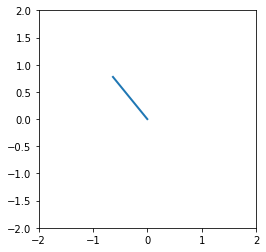

In [122]:
fig, ax = plt.subplots()

ax.set_xlim(( -2, 2))
ax.set_ylim((-2, 2))
ax.set_aspect(1)

line, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)

saved_traj_num=2
trajectory = savedTrajectories[saved_traj_num][0,:]
inputs = savedInputs[saved_traj_num]

def init():
    line.set_data([0,np.sin(th0)], [0,np.cos(th0)])
    line2.set_data([0,0], [-1.5,-1.5])
    return (line,line2)

def animate(i):
    tip_x = np.sin(trajectory[i])
    tip_y = np.cos(trajectory[i])

    line.set_data([0,tip_x], [0,tip_y])
    line2.set_data(
        [tip_x,tip_x + np.sin(trajectory[i]+np.pi/2)*inputs[i]],
        [tip_y,tip_y + np.cos(trajectory[i]+np.pi/2)*inputs[i]]
    )
    # line2.set_data([0, inputs[i]], [-1.5,-1.5])
    return (line,line2)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(trajectory), interval=1000*.05, 
                               blit=True)

HTML(anim.to_jshtml())
# env = gym.make("Pendulum-v0")

# num_runs=1
# for i in range(num_runs):
#     print(f"showing {i} of {num_runs} runs")
#     state = env.reset()
#     for action in savedInputs[i]:
#         print(action)
#         env.render()
#         # action = agent.act(state)
#         next_state, reward, done, _ = env.step([action])
#         # state = next_state
#         # if done:
#         #     break
# env.close()

In [86]:
env.close()

In [88]:
savedInputs

[DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 DeviceArray([ 0.04610538,  0.1735208 ,  0.29665944,  0.41259027,
               0.5174645 ,  0.60649914,  0.6743008 ,  0.71555936,
               0.72599113,  0.70705324,  0.6676133 ,  0.60944843,
               0.5356624 ,  0.44993725,  0.35584837,  0.25642416,
               0.15399578,  0.05028946, -0.05332298, -0.15548867,
              -0.25451422, -0.3480401 , -0.43282425, -0.50473225,
              -0.559032  , -0.59102625, -0.5969125 , -0.5793065 ,
              -0.546128